<a href="https://colab.research.google.com/github/ikram-hamizi/AML-DS-2021/blob/main/AML_HW2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Innopolis University - Spring 2021
- **Student**: Ikram Hamizi
- **Professor**: Muhammad Fahim
- **Teaching Assistant**: ‪Gcinizwe Dlamini‬
- **Homework (2) Task**: Collaborative Filtering for Recommender Systems [Link](https://hackmd.io/@gFZmdMTOQxGFHEFqqU8pMQ/B1z1pP6L_)

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [86]:
!pip install wget

In [4]:
# import libraries
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from scipy.sparse import csr_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import wget
from zipfile import ZipFile
from sklearn.metrics import mean_squared_error

# Setting the environment
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
torch.set_default_dtype(torch.float64)

In [5]:
# Download the data
wget.download("https://github.com/Gci04/AML-DS-2021/raw/main/data/collaborative-filtering.zip")

with ZipFile("collaborative-filtering.zip", 'r') as f:
  f.extractall()

## 1// **Data Exploration**

In [6]:
# Read the data
train = pd.read_csv("collaborative-filtering/train.csv")
test = pd.read_csv("collaborative-filtering/test.csv")

train.head()

,userId,movieId,rating
0,1,32,3.5
1,1,47,3.5
2,1,50,3.5
3,1,253,4.0
4,1,260,4.0


In [7]:
# Print important information
unique_users = train['userId'].unique()
unique_movies = train['movieId'].unique()

U = len(unique_users)
I = len(unique_movies) 

print("Number of unique users: ", U)
print("Number of unique movies: ", I)
print("Length of the dataset: ", len(train))
print("Length of the sparse matrix: ", U*I) #UxI

Number of unique users:  6687
Number of unique movies:  5064
Length of the dataset:  761972
Length of the sparse matrix:  33862968


In [8]:
known_ratings_percentage = 100*(len(train))/(U*I)
print(f"The percentage of known ratings: θ% = {known_ratings_percentage}%")

The percentage of known ratings: θ% = 2.2501630689902905%


Text(0.5, 1.0, 'Histogram of ratings frequency (binned)')

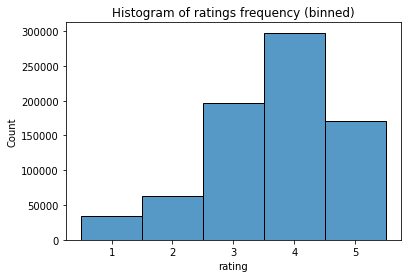

In [9]:
# Print the histogram
sns.histplot(data=train, x="rating", binwidth=1).set_title("Histogram of ratings frequency (binned)")

In [10]:
# TRAINING SET: Get the the user-item matrix (dense)

df_user_item = train.pivot(index='userId', columns='movieId', values='rating').fillna(0)
df_user_item.head(3)

movieId,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,34,35,36,38,39,40,41,42,...,106002,106072,106100,106487,106489,106642,106696,106766,106782,106916,106918,106920,107141,107406,108190,108932,109374,109487,110102,110553,110730,111360,111362,111364,111659,111759,112138,112175,112183,112290,112552,112556,112623,112852,114180,115569,115617,116797,116823,118696
userId,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [11]:
# TESTING SET: Get the the user-item matrix (dense)

df_user_item_test = test.pivot(index='userId', columns='movieId', values='rating').fillna(0)
df_user_item_test.head(3)

movieId,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,34,35,36,38,39,40,41,42,...,106002,106072,106100,106487,106489,106642,106696,106766,106782,106916,106918,106920,107141,107406,108190,108932,109374,109487,110102,110553,110730,111360,111362,111364,111659,111759,112138,112175,112183,112290,112552,112556,112623,112852,114180,115569,115617,116797,116823,118696
userId,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,0.0,3.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0







## 2// **Implementing Collaborative Filtering Recommener Systems**





### a. PREPROCESSING THE DATA

In [12]:
# PREPROCESS THE TESTING User-Item matrix

df_user_item_test.shape, df_user_item.shape
# ((6674, 5059),(6687, 5064)) The sahpes are not equal.
# Fix this by adding the missing userId's and movieId's:


# 1. Add missing userId's and movieId's to the test set
df_user_item_test = df_user_item_test.reindex(
    columns= df_user_item_test.columns | df_user_item.columns,
    index  = df_user_item_test.index   | df_user_item.index)

# 2. Fill the NaN values with 0's
df_user_item_test = df_user_item_test.fillna(0)

# 3. Assert that the training set and the test set are disjoint
assert np.all(df_user_item_test.values * df_user_item.values == 0)

### b. GLOBAL VARIABLES

In [13]:
# GET THE RATINGS DENSE MATRICES

Y = df_user_item.values.copy()
Y_test = df_user_item_test.values.copy()

unique_users = train['userId'].unique()   #6687 
unique_movies = train['movieId'].unique() #5064

U = len(unique_users)
I = len(unique_movies)

total_ratings = len(train)
total_ratings_test = len(test)

k = 50




---



#1. Collaborative Filtering model: **Matrix Factorization**


---




### **MF FUNCTIONS**

**Loss Function with L2 Regularization** 

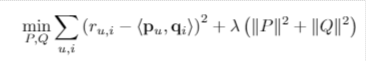

In [14]:
def MSE(error, A, B, total_ratings, C=0, squared=True): 
        
  squared_magnitude_P = (A @ A.T).sum()
  squared_magnitude_Q = (B @ B.T).sum()

  # MSE
  regularization = C*(squared_magnitude_P + squared_magnitude_Q)
  loss = ((error**2).sum() + regularization)/(total_ratings)
  
  # RMSE
  if not squared:
    loss = np.sqrt(loss)                                                                   

  return loss

In [15]:
class MatrixFactorization:
  
  def __init__(self, Y, Y_test, U, I, total_ratings, total_ratings_test, optimization):
    """
    args:
      - Y:       matrix of train ratings (ratings allow to complete the missing values)
	    - Y_test:  matrix of test ratings  (true ratings to be compared with predictions)
      
      - U: total number of users
      - I: total number of items (movies)
      
      - total_ratings     : total number of observed ratings (trainset)
      - total_ratings_test: total number of observed ratings (test-set)
      
      - Optimization: 'SGD' or 'ALS':  
    """
    self.Y = Y
    self.Y_test = Y_test
    self.optimization = optimization
    self.U = U
    self.I = I
    self.total_ratings = total_ratings
    self.total_ratings_test = total_ratings_test


  def get_matrices(self, K=50, C=0, tup=None, n_epochs=50, squared=True, lr=7e-5):
    """
		args:
		  - K:        number of factors in the latent vectors
	      - C:        regularization factor
	      - lr: 	  learning rate
	      - tup:      range tuple to initialize the low rank matrices 
	      - n_epochs: number of epochs
	      - squared:  MSE loss if Talse, RMSE loss if True (default: True)
	      - beta:     for momentum calculation
    """
    
    if self.optimization == 'SGD':
      return get_MF_with_GD(self.Y, self.Y_test, self.U, self.I, self.total_ratings, self.total_ratings_test, K, C, tup, n_epochs, squared, lr)


    elif self.optimization == 'ALS':
      return get_MF_with_ALS(self.Y, self.Y_test, self.U, self.I, self.total_ratings, self.total_ratings_test, K, C, tup, n_epochs, squared)

    else:
      print("You can only choose 'SGD' or 'ALS'")
   
    
    

###**1.1 ALS OPTIMIZATION METHOD**

*Note*: The algorithm for ALS is slightly modified in this image to show the closed form equations using matrices.

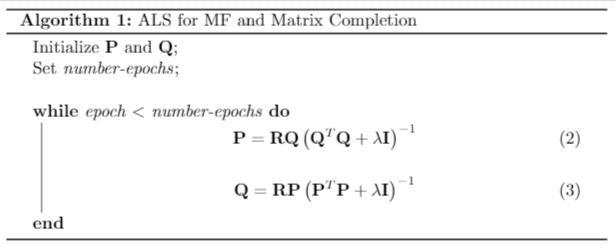

In [27]:
def get_MF_with_ALS(Y, Y_test, U, I, total_ratings, total_ratings_test, K=50, C=0.01, tup=None, n_epochs=50, squared=True):
    """-
    args:
        - Y:        matrix of train ratings (ratings allow to complete the missing values)
        - Y_test:   matrix of test ratings  (true ratings to be compared with predictions)

        - K:        number of factors in the latent vectors
        - C:        regularization factor
        - tup:      range tuple to initialize the low rank matrices 
        - n_epochs: number of epochs
        - squared:  MSE loss if Talse, RMSE loss if True (default: True)

    return:
        - P, Q, train_losses, test_losses
    """
    

    def ALS(movie_features, fixed_matrix, k, C):
      """
      args:
        movie_features: the User-Item matrix (R)
        fixed_matrix: the fixed latent matrix (use P if updating Q and vice versa)
        k: number of factors in latent vectors
        C: Regularization parameter

      return:
        updated matrix after ALS
      
      e.g.: P = R*Q*(Q.T*Q + λ*I)^{-1}
      """  
      updated_matrix = movie_features @ fixed_matrix @ np.linalg.inv(fixed_matrix.T @ fixed_matrix + C * np.eye(k))
      return updated_matrix
      
    train_mask = np.nonzero(Y)
    test_mask = np.nonzero(Y_test)
      
    def error_with_mask(Y, Y_pred, dataset):
      """
      Function: returns the difference between Y and Y_pred, i.e. error or deviance
      args:
        Y:      matrix of true ratings 
        Y_pred: matrix of predicted ratings 
      """

      if dataset == 'train':
        mask = train_mask
      elif dataset == 'test':
        mask = test_mask
      else:
        return
      error = Y[mask] - Y_pred[mask]
      return error
  
  
    if not isinstance(tup, tuple) and tup is not None:
      print("Error: You passed a non-tuple object. \
      Pass a tuple of the form (minimum_value, maximum_value) to initialize the latent vectors.")

    #mu = np.mean(Y[np.where(Y!=0)]) # Global Average
    #user_ratings_mean = np.mean(Y, axis=1)

    P = np.random.random(size=(U,k)) #user latent matrix
    Q = np.random.random(size=(I,k)) #item latent matrix

    if tup is not None:
      P = np.random.uniform(tup[0],tup[1], size=(U,k)) #default (0,1)
      Q = np.random.uniform(tup[0],tup[1], size=(I,k)) #default (0,1)

    train_losses = []
    test_losses = []

    loss_type = 'MSE' if squared else 'RMSE'

    for epoch in range(n_epochs):

        P = ALS(Y, Q, k, C)
        Q = ALS(Y.T, P, k, C)

        Y_pred = (P @ Q.T)
        
        train_error = error_with_mask(Y, Y_pred, dataset='train')
        test_error  = error_with_mask(Y_test, Y_pred, dataset='test')

        train_LOSS = MSE(train_error, P, Q, total_ratings, C=C, squared=squared)
        test_LOSS  = MSE(test_error, P, Q, total_ratings_test, squared=squared)

        train_losses.append(train_LOSS)
        test_losses.append(test_LOSS)

        if (epoch==0 or (epoch+1)%10 == 0):
          print(f"\nEpoch: {epoch+1}/{n_epochs}")
          print(f"Train {loss_type} (λ={C}) = {train_LOSS}") #, DEBUG: {mean_squared_error(Y[train_mask], Y_pred[train_mask])}")
          print(f"Test  {loss_type}    (λ=0) = {test_LOSS}") #, DEBUG: {mean_squared_error(Y_test[test_mask], Y_pred[test_mask])}")

          
    return P, Q, train_losses, test_losses

###**1.2 GRADIENT DESCENT OPTIMIZATION METHOD**

*Note*: The algorithm for GD is slightly modified in this image to show the closed form equations using matrices.


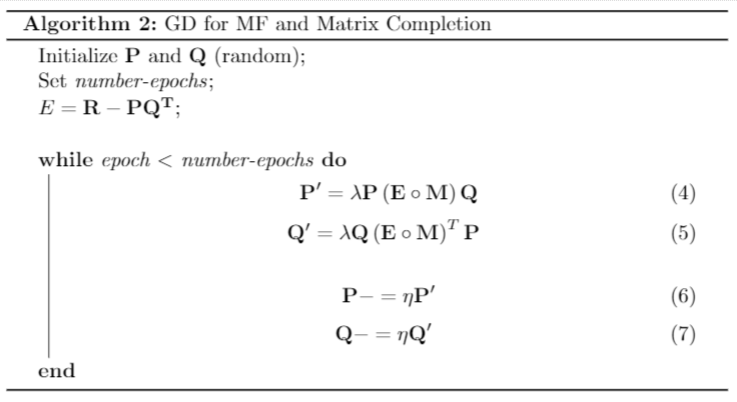

In [17]:
def get_MF_with_GD(Y, Y_test, U, I, total_ratings, total_ratings_test, K=50, C=0, tup=None, n_epochs=50, squared=True, lr=7e-5):
  """-
  args:
      - Y:        matrix of train ratings (ratings allow to complete the missing values)
      - Y_test:   matrix of test ratings  (true ratings to be compared with predictions)
		
      - K:        number of factors in the latent vectors
      - C:        regularization factor
      - tup:      range tuple to initialize the low rank matrices 
      - n_epochs: number of epochs
      - squared:  MSE loss if Talse, RMSE loss if True (default: True)

      - lr: 	    learning rate
      - beta:     for momentum calculation

  return:
      - P, Q, train_losses, test_losses
  """
  M_train = Y.copy()
  M_train[M_train>0] = 1

  M_test = Y_test.copy()
  M_test[M_test>0] = 1

  P = np.full((U,k), 0.1) #user latent matrix (Simon Funk)
  Q = np.full((I,k), 0.1) #item latent matrix (Simon Funk)

  if tup is not None:
    P = np.random.uniform(tup[0],tup[1], size=(U,k)) #default (0,1)
    Q = np.random.uniform(tup[0],tup[1], size=(I,k)) #default (0,1)

  train_losses_gd = []
  test_losses_gd = []

  train_mask = np.nonzero(Y)
  test_mask = np.nonzero(Y_test)

  # get initial error
  Y_pred = P @ Q.T
  train_error = (Y - Y_pred) * M_train

  loss_type = 'MSE' if squared else 'RMSE'

  for epoch in range(n_epochs):

        P_grad = (C*P - (train_error)   @ Q) 
        Q_grad = (C*Q - (train_error).T @ P)

        P -= (lr*P_grad)
        Q -= (lr*Q_grad)

        Y_pred = (P @ Q.T)
        
        train_error = (Y      - Y_pred) * M_train
        test_error  = (Y_test - Y_pred) * M_test

        train_LOSS = MSE(train_error, P, Q, total_ratings, C=C, squared=squared)
        test_LOSS  = MSE(test_error, P, Q, total_ratings_test, squared=squared)

        train_losses_gd.append(train_LOSS)
        test_losses_gd.append(test_LOSS)

        if epoch == 0 or (epoch+1)%2 == 0:
          print(f"\nEpoch: {epoch+1}/{n_epochs}")
          print(f"Train {loss_type} (λ={C}) = {train_LOSS}")
          print(f"Test  {loss_type}    (λ=0) = {test_LOSS}, {mean_squared_error(Y_test[test_mask], Y_pred[test_mask])}")
  
  return P, Q, train_losses_gd, test_losses_gd



---


#2. Collaborative Filtering model: **Deep Learning**


---



1. Input: integer values (ohe values cane also be used)
2. 2 embedding layers: User emb + Item emb
3. Concatenate embedding layers
4. FC hidden layers (regularization: dropout)
5. Output layer: range [1,5]

In [18]:
# Setting the environment
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
torch.set_default_dtype(torch.float64)

class NCF_Recommender(nn.Module):
  
  def __init__(self, n_users, n_movies, train, lr=1e-3, k=50):
    
    super().__init__()
     
    self.n_users = n_users
    self.n_movies = n_movies
    self.train = train
    self.lr = lr
    self.k = k
    
    self.emb1 = nn.Embedding(n_users,  k)
    self.emb2 = nn.Embedding(n_movies, k)
	    
    self.hidden = nn.Sequential(
	      nn.Dropout(0.2),
	      nn.Flatten(),
	      nn.Linear(k*2 , 512),
	      nn.Dropout(0.2),
	      nn.ReLU(),
	      nn.Linear(512, 256),
	      nn.Dropout(0.2),
	      nn.ReLU(),
	      nn.Linear(256, 128),
	      nn.Dropout(0.2),
	      nn.ReLU(),
	      nn.Linear(128, 1)
       )
	  
    self.sigmoid = nn.Sigmoid()
    self._init()
  
  def forward(self, users, movies, range=(1,5)):
	  x = torch.cat([self.emb1(users), self.emb2(movies)], dim=1)
	  x = self.hidden(x)
	  x = self.sigmoid(x)

	  min, max = range
	    
	  return x*(max - min + 1) + min - 0.5  #scale output back to [1,5]

  # Copied: from AML Lab 8
  def _init(self):
    """
	  Initialize embeddings and hidden layers weights with xavier.
	  """
    def init(m):
      if type(m) == nn.Linear:
        torch.nn.init.xavier_uniform_(m.weight)
        m.bias.data.fill_(0.01)

    self.emb1.weight.data.uniform_(-0.05, 0.05)
    self.emb2.weight.data.uniform_(-0.05, 0.05)
    self.hidden.apply(init)


  def fit(self, n_epochs=30):
    	
    def _prepare_batches():
        # Creating Batches of size batch_sizee each
        batch_size = 128
        batches = []

        #>>>>temp data
        users = self.train['userId'].values
        movies = self.train['movieId'].values
        ratings = self.train['rating'].values

        R = len(ratings)

        #Create bathces of data
        for i in range(0, R, batch_size):
          limit = min(i+batch_size, R)

          users_batch = torch.tensor(users[i:limit], dtype=torch.long)
          movies_batch = torch.tensor(movies[i:limit], dtype=torch.long)
          ratings_batch = torch.tensor(ratings[i:limit], dtype=torch.float64)

          batches.append((users_batch, movies_batch, ratings_batch))

        #<<<<delete temp data
        del users
        del movies
        del ratings

        return batches

    batches = _prepare_batches()

    criterion = nn.MSELoss()
    optimizer = optim.Adam(self.parameters(), lr=self.lr)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.3, patience=2)
    
    losses = []

    for epoch in range(n_epochs):
      epoch_loss = []
      for users_batch, movies_batch, ratings_batch in batches:
        
        model.zero_grad()
        y_pred = model(users_batch.to(device), movies_batch.to(device)).squeeze()
        loss = criterion(ratings_batch.to(device), y_pred)

        epoch_loss.append(loss.item())
        loss.backward()
        optimizer.step()
        
      epoch_loss_mean = np.mean(epoch_loss)
      losses.append(epoch_loss_mean)
      scheduler.step(epoch_loss_mean)
      
      print(f"Epoch {epoch+1}/{n_epochs}, Epoch Loss = {epoch_loss_mean}")

    return losses

#3. Compare: **Matrix Factorization** vs **Deep Learning**

### a. **TRAINING**

In [19]:
k = 50

In [31]:
# 1/ MATRIX FACTORIZATION: with ALS (Alternating Least Squares) - verbose = True
print()
print("-----" * 13)
print("1. Completing the User-Item matrix with Matrix Factorization: ALS")
print("-----" * 13)

MFObject1 = MatrixFactorization(Y, Y_test, U, I, total_ratings, total_ratings_test, 'ALS')
P1, Q1, train_loss1, test_loss1 = MFObject1.get_matrices(K=20, C=2e-1, tup=(0, 1/np.sqrt(k)), n_epochs=50, squared=True)


-----------------------------------------------------------------
1. Completing the User-Item matrix with Matrix Factorization: ALS
-----------------------------------------------------------------

Epoch: 1/50
Train MSE (λ=0.2) = 11.370723517258952
Test  MSE    (λ=0) = 9.141284477161639

Epoch: 10/50
Train MSE (λ=0.2) = 9.884507245062252
Test  MSE    (λ=0) = 7.814883211092878

Epoch: 20/50
Train MSE (λ=0.2) = 9.811210588918714
Test  MSE    (λ=0) = 7.804450482955779

Epoch: 30/50
Train MSE (λ=0.2) = 9.751886617974996
Test  MSE    (λ=0) = 7.802983643865628

Epoch: 40/50
Train MSE (λ=0.2) = 9.69785753884149
Test  MSE    (λ=0) = 7.802790231588583

Epoch: 50/50
Train MSE (λ=0.2) = 9.64746959926849
Test  MSE    (λ=0) = 7.802764492467678


In [89]:
# 2/ MATRIX FACTORIZATION: with GD (Gradient Descent)			- verbose = True
print()
print("-----"*13)
print("2. Completing the User-Item matrix with Matrix Factorization: GD")
print("-----" *13, '\n')

MFObject2 = MatrixFactorization(Y, Y_test, U, I, total_ratings, total_ratings_test, 'SGD')
P2, Q2, train_loss2, test_loss2 = MFObject2.get_matrices(K=50, C=0, tup=(0,1), n_epochs=40, squared=True, lr=8e-5)


-----------------------------------------------------------------
2. Completing the User-Item matrix with Matrix Factorization: GD
----------------------------------------------------------------- 


Epoch: 1/40
Train MSE (λ=0) = 23.58534893501665
Test  MSE    (λ=0) = 23.629892174242617, 23.629892174242563

Epoch: 2/40
Train MSE (λ=0) = 14.125587863974037
Test  MSE    (λ=0) = 14.257478043123886, 14.257478043123902

Epoch: 4/40
Train MSE (λ=0) = 8.344525779426151
Test  MSE    (λ=0) = 8.490326637286005, 8.490326637286

Epoch: 6/40
Train MSE (λ=0) = 5.931081701547303
Test  MSE    (λ=0) = 6.077884685003945, 6.077884685003934

Epoch: 8/40
Train MSE (λ=0) = 4.767382757866019
Test  MSE    (λ=0) = 4.914561386009862, 4.914561386009852

Epoch: 10/40
Train MSE (λ=0) = 4.129920966567007
Test  MSE    (λ=0) = 4.278815361674181, 4.278815361674188

Epoch: 12/40
Train MSE (λ=0) = 3.715139135505112
Test  MSE    (λ=0) = 3.866613932143636, 3.866613932143643

Epoch: 14/40
Train MSE (λ=0) = 3.4114917341021

In [33]:
# 3/ DEEP LEARNING (Neural Collaborative Filtering)				- verbose = True
print()
print("-----" * 5)
print("3. Completing the User-Item matrix Neural Collaborative Filtering")
print("-----" * 5, '\n'); 
model = NCF_Recommender(n_users=max(unique_users)+1, n_movies=max(unique_movies)+1, train=train, lr=1e-3, k=50).to(device)
losses = model.fit(n_epochs=30)
torch.save(model, 'NCF_model_HW2.pth')
torch.save(model, '/content/drive/MyDrive/NCF_model_HW2.pth')


-------------------------
3. Completing the User-Item matrix Neural Collaborative Filtering
------------------------- 

Epoch 1/30, Epoch Loss = 0.906460118203871
Epoch 2/30, Epoch Loss = 0.7792116536385099
Epoch 3/30, Epoch Loss = 0.7398355403607656
Epoch 4/30, Epoch Loss = 0.7194329364367577
Epoch 5/30, Epoch Loss = 0.7037589916345962
Epoch 6/30, Epoch Loss = 0.6897710830948229
Epoch 7/30, Epoch Loss = 0.6774927580197236
Epoch 8/30, Epoch Loss = 0.6669228774697821
Epoch 9/30, Epoch Loss = 0.6592602807403298
Epoch 10/30, Epoch Loss = 0.6494527771012697
Epoch 11/30, Epoch Loss = 0.6423061419335071
Epoch 12/30, Epoch Loss = 0.6350352763988895
Epoch 13/30, Epoch Loss = 0.6285145356592884
Epoch 14/30, Epoch Loss = 0.6221994110427884
Epoch 15/30, Epoch Loss = 0.6153894453058367
Epoch 16/30, Epoch Loss = 0.6088899043625263
Epoch 17/30, Epoch Loss = 0.6032666257375311
Epoch 18/30, Epoch Loss = 0.5969473103880225
Epoch 19/30, Epoch Loss = 0.590129958901768
Epoch 20/30, Epoch Loss = 0.5841055

### b. **COMPARING THE LOSS VALUES (MSE)**

1. Matrix Factorization Model loss (ALS)
----------------------------------------


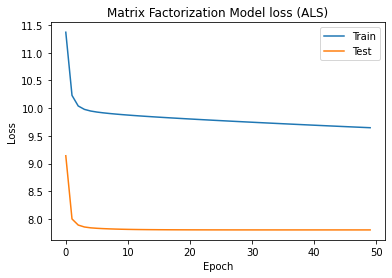

In [34]:
print("1. Matrix Factorization Model loss (ALS)")
print("-----"*8)
plt.plot(train_loss1)
plt.plot(test_loss1)
plt.title('Matrix Factorization Model loss (ALS)')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc = 'best')
plt.show()

Matrix Factorization Model loss (GD)
----------------------------------------


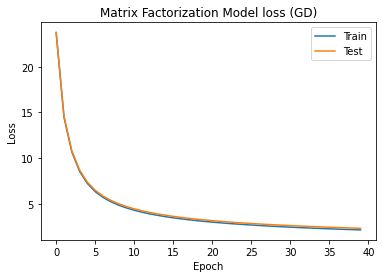

In [35]:
print("Matrix Factorization Model loss (GD)")
print("-----"*8)
plt.plot(train_loss2)
plt.plot(test_loss2)
plt.title('Matrix Factorization Model loss (GD)')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc = 'best')
# plt.legend(['Test'], loc = 'best')
plt.show()

2. Neural Network Model loss
------------------------


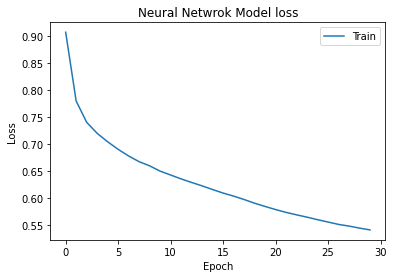

In [36]:
print("2. Neural Network Model loss")
print("---"*8)
plt.plot(losses)
plt.title('Neural Netwrok Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train'], loc = 'best')
plt.show()

#4. Top-5 recommended movies for a user

In [81]:
# Function: returns a dataframe of unique movieIds
def get_list_of_all_movies(df_train):
  return pd.DataFrame(data=df_train['movieId'].unique(), columns=['movieId']) #movieIds 

movieIds = get_list_of_all_movies(train)

# Function: recommends movies
def recommend_movies(userID, df_movieIds, df_train, technique, n=5, df_preds_MF=None, model=None):

  """ Function: returns top-5 recommended movies for userID
      args:
          userID: userId in training set

          df_movieIds: all unique movies in the training set (DataFrame of all unique movieId's) 

          df_train: training set (DataFrame with at least three columns: userId, movieId, rating)

          technique: 'NN' for Neural Network and 'MF' for Matrix Factorization

          df_preds_MF: reconstructed matrix from matrix factorization if technique == 'MF'

          model: NN model if technique == 'NN'
  """

  if technique != 'NN' and technique != 'MF':
    print("You must enter the 'technique' type correctly: 'MF' for Matrix Factorization or 'NN' for Neural Network")
    return;

  #1. >get       watched movieIds by the user  +  sort them by rating (descending)
  movies_watched = df_train[df_train.userId == (userID)].sort_values(['rating'], ascending=False) # get all userId:	movieId, rating


  #2. >get >NOT< watched movieIds by the user
  movies_not_watched = df_movieIds[~df_movieIds['movieId'].isin(movies_watched['movieId'])]

  # MATRIX FACTORIZATION
  if technique == 'MF':
    #3.` get all movieIds that exist in the dataset + sort them by rating (descending)
    sorted_user_predictions = df_preds_MF[df_preds_MF.index==userID].sort_values(by=userID, axis=1, ascending=False)
    sorted_user_predictions = pd.DataFrame(np.transpose(sorted_user_predictions.values), columns=sorted_user_predictions.index, index=sorted_user_predictions.columns)
 

    #4.` get predictions for NON-watched movies
    recommendations = (movies_not_watched).merge(
        pd.DataFrame(sorted_user_predictions).reset_index(),
        how = 'left', left_on = 'movieId', right_on = 'movieId').rename(
            columns = {userID: 'Predictions'}).sort_values(
                'Predictions', ascending = False).iloc[:n]
  
  # NEURAL COLLABORATIVE FILTERING
  elif technique == 'NN':
    user = [userID] * len(movies_not_watched) #userID (repeated)
    new_movies = movies_not_watched['movieId'].tolist() #non-watched movies

    user = torch.tensor(user).to(device=device, dtype=torch.long) 
    new_movies = torch.tensor(new_movies).to(device=device, dtype=torch.long)

    rating_preds = model(user, new_movies).squeeze() # get a list of predicted ratings from the model

    # 3.`` prepare the data for the model
    new_movies = new_movies.cpu().detach().tolist() 
    rating_preds = rating_preds.cpu().detach().tolist()
    data = {"movieId":new_movies, userID:rating_preds}

    #4.`` get predictions for NON-watched movies
    recommendations = pd.DataFrame(data).sort_values(by=userID, ascending=False) # this list only has non-watched movies
    
  if 'index' in recommendations.columns:
    recommendations.drop(columns='index') 

  return movies_watched.iloc[:n], recommendations

def predictMF(userID, P, Q, df_train):
  # Get the predictions from Matrix Factorization technique.
  y_predicted = P @ Q.T
  preds_df = pd.DataFrame(y_predicted, columns = df_user_item.columns)

  # Get top 5 recommneded movies for user with id "330"
  y_test_df, y_predicted_df = recommend_movies(userID, movieIds, df_train, technique='MF', df_preds_MF=preds_df)

  return y_test_df, y_predicted_df

def predictNN(userID, model, df_train):
  # Get top 5 recommneded movies for user with id "330" with NN technique
  y_test_df, y_predicted_df = recommend_movies(userID, movieIds, df_train, technique='NN', model=model)

  return y_test_df, y_predicted_df

##1. Matrix Factorization

In [127]:
userID = 330

In [128]:
#ALS
top_liked_by_user, new_predicted_to_user = predictMF(userID, P1, Q1, train)

In [129]:
print("****" * 8)
print(f"Top 5 liked movies by user {userID}")
print("****" * 8)

# 1/ Real Ratings
top_liked_by_user.head()

********************************
Top 5 liked movies by user 330
********************************


,userId,movieId,rating
32806,330,17,5.0
32948,330,588,5.0
32820,330,47,5.0
32894,330,296,5.0
32821,330,50,5.0


In [130]:
print("✰✰✰✰✰✰✰✰✰✰✰✰✰  Ground Truth  ✰✰✰✰✰✰✰✰✰✰✰✰✰")
print("====" * 14)
print(f"Top 5 new movie recommendations for user {userID} -- TEST SET")
print("====" * 14)
new_predicted_to_user_TRUE = test[test.userId == (userID)].sort_values(['rating'], ascending=False) # get all userId:	movieId, rating
new_predicted_to_user_TRUE.head()

✰✰✰✰✰✰✰✰✰✰✰✰✰  Ground Truth  ✰✰✰✰✰✰✰✰✰✰✰✰✰
Top 5 new movie recommendations for user 330 -- TEST SET


,userId,movieId,rating
8282,330,349,5.0
8253,330,110,5.0
8270,330,262,4.0
8289,330,421,4.0
8271,330,272,4.0


In [131]:
print("----" * 14)
print(f"Top 5 new movie recommendations for user {userID} -- MF (ALS)")
print("----" * 14)

# 2/ Predicted Rating s
new_predicted_to_user.head()

--------------------------------------------------------
Top 5 new movie recommendations for user 330 -- MF (ALS)
--------------------------------------------------------


,movieId,Predictions
170,457,2.976248
300,608,2.815699
472,349,2.154139
132,480,2.049029
285,377,2.043591


In [132]:
#GD
_, new_predicted_to_user = predictMF(userID, P2, Q2, train)

In [133]:
print("✰✰✰✰✰✰✰✰✰✰✰✰✰  Ground Truth  ✰✰✰✰✰✰✰✰✰✰✰✰✰")
print("====" * 14)
print(f"Top 5 new movie recommendations for user {userID} -- TEST SET")
print("====" * 14)
new_predicted_to_user_TRUE = test[test.userId == (userID)].sort_values(['rating'], ascending=False) # get all userId:	movieId, rating
new_predicted_to_user_TRUE.head()

✰✰✰✰✰✰✰✰✰✰✰✰✰  Ground Truth  ✰✰✰✰✰✰✰✰✰✰✰✰✰
Top 5 new movie recommendations for user 330 -- TEST SET


,userId,movieId,rating
8282,330,349,5.0
8253,330,110,5.0
8270,330,262,4.0
8289,330,421,4.0
8271,330,272,4.0


In [134]:
print("----" * 13)
print(f"Top 5 movie recommendations for user {userID} -- MF (GD)")
print("----" * 13)

# 2/ Predicted Rating s
new_predicted_to_user.head()

----------------------------------------------------
Top 5 movie recommendations for user 330 -- MF (GD)
----------------------------------------------------


,movieId,Predictions
4043,1757,10.417830
2472,4991,10.334399
3530,90249,10.196151
4764,5694,10.158310
4105,6686,10.142242


##2. Neural Network Model

In [135]:
top_liked_by_user, new_predicted_to_user = predictNN(userID, model, train)

In [136]:
print("****" * 8)
print(f"Top 5 liked movies by user {userID}")
print("****" * 8)

# 1/ Real Ratings
top_liked_by_user.head()

********************************
Top 5 liked movies by user 330
********************************


,userId,movieId,rating
32806,330,17,5.0
32948,330,588,5.0
32820,330,47,5.0
32894,330,296,5.0
32821,330,50,5.0


In [137]:
print("✰✰✰✰✰✰✰✰✰✰✰✰  Ground Truth  ✰✰✰✰✰✰✰✰✰✰✰✰")
print("====" * 13)
print(f"Top 5 movie recommendations for user {userID} -- TEST SET")
print("====" * 13)
new_predicted_to_user_TRUE = test[test.userId == (userID)].sort_values(['rating'], ascending=False) # get all userId:	movieId, rating
new_predicted_to_user_TRUE.head()

✰✰✰✰✰✰✰✰✰✰✰✰  Ground Truth  ✰✰✰✰✰✰✰✰✰✰✰✰
Top 5 movie recommendations for user 330 -- TEST SET


,userId,movieId,rating
8282,330,349,5.0
8253,330,110,5.0
8270,330,262,4.0
8289,330,421,4.0
8271,330,272,4.0


In [138]:
print("----" * 12)
print(f"Top 5 movie recommendations for user {userID} -- NN")
print("----" * 12)

# 2/ Predicted Rating s
new_predicted_to_user.head()

------------------------------------------------
Top 5 movie recommendations for user 330 -- NN
------------------------------------------------


,movieId,330
2188,73344,4.612003
177,858,4.587872
116,7153,4.439532
4081,7060,4.415844
3746,3307,4.407543
